In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.wkt import loads
import numpy as np
import os
from shapely.geometry import Polygon

Error parsing WKT at index 2: ParseException: Expected number but encountered ')'
Error parsing WKT at index 3: ParseException: Expected number but encountered ')'
Error parsing WKT at index 9: ParseException: Expected number but encountered ')'
Error parsing WKT at index 15: ParseException: Expected number but encountered ')'
Error parsing WKT at index 33: ParseException: Expected number but encountered ')'
Error parsing WKT at index 57: ParseException: Expected number but encountered ')'
Error parsing WKT at index 59: ParseException: Expected number but encountered ')'
Error parsing WKT at index 64: ParseException: Expected number but encountered ')'
Error parsing WKT at index 86: ParseException: Expected number but encountered ')'
Error parsing WKT at index 101: ParseException: Expected number but encountered ')'
Error parsing WKT at index 127: ParseException: Expected number but encountered ')'
Error parsing WKT at index 132: ParseException: Expected number but encountered ')'
Erro

C:\Users\perry\AppData\Local\Temp\ipykernel_23596\2643038696.py:78: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
C:\Users\perry\AppData\Local\Temp\ipykernel_23596\2643038696.py:78: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


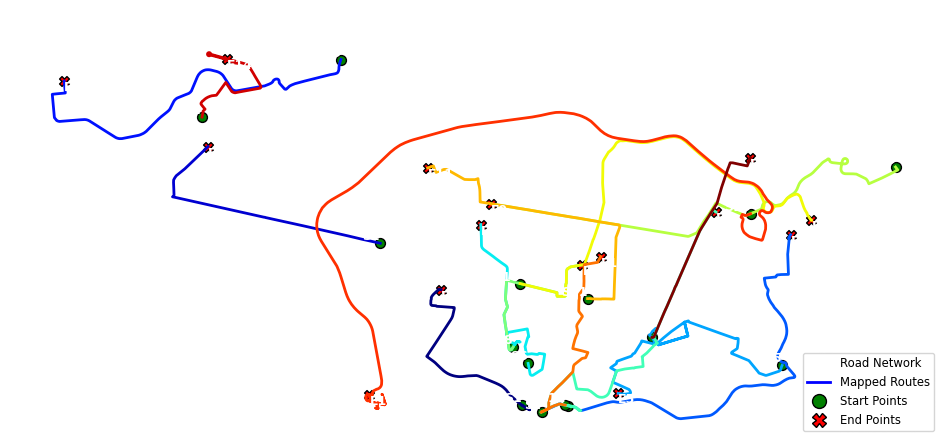

Image saved to data\Mapped Trajectories_of_first_15_trips1.png


In [14]:
def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    """
    Calculate the boundaries of the coordinates.
    """
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

def visualize_first_15_routes(output_csv_file):
    # Check if the file exists
    if not os.path.exists(output_csv_file):
        print(f"File not found: {output_csv_file}")
        return
    
    df = pd.read_csv(output_csv_file)

    geometries = []
    for idx, wkt in enumerate(df['mgeom']):
        try:
            geometry = loads(wkt)
            geometries.append(geometry)
        except Exception as e:
            print(f"Error parsing WKT at index {idx}: {e}")
            geometries.append(None)
    df['geometry'] = geometries
    df = df.dropna(subset=['geometry'])

    if df.empty:
        print("No valid geometries found.")
        return

    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

    current_x_max = current_y_max = current_x_min = current_y_min = None
    is_first = True

    num_routes = min(15, len(gdf))
    colors = plt.cm.jet(np.linspace(0, 1, num_routes))  # Retained 'jet' colormap

    for i, geometry in enumerate(gdf['geometry'].head(num_routes)):
        if geometry.geom_type == 'LineString':
            x, y = geometry.xy
            for lon, lat in zip(x, y):
                current_x_max, current_y_max, current_x_min, current_y_min, is_first = calculate_boundaries(
                    current_x_max, current_y_max, current_x_min, current_y_min, is_first, lon, lat
                )
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                x, y = line.xy
                for lon, lat in zip(x, y):
                    current_x_max, current_y_max, current_x_min, current_y_min, is_first = calculate_boundaries(
                        current_x_max, current_y_max, current_x_min, current_y_min, is_first, lon, lat
                    )


    if is_first:
        print("Could not calculate boundaries. Using default values.")
        current_x_min, current_x_max = -8.7, -8.5  # Approximate bounds for Porto
        current_y_min, current_y_max = 41.1, 41.3
    else:
        # Add some padding to the boundaries
        x_padding = (current_x_max - current_x_min) * 0.05
        y_padding = (current_y_max - current_y_min) * 0.05
        current_x_min -= x_padding
        current_x_max += x_padding
        current_y_min -= y_padding
        current_y_max += y_padding

    north, south, east, west = current_y_max, current_y_min, current_x_max, current_x_min
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        bgcolor='black',
        edge_color='white',
        node_size=0,
        edge_linewidth=0.5,  
        figsize=(12, 12)
    )

    # Plot the routes
    for i, geometry in enumerate(gdf['geometry'].head(num_routes)):
        label = f"Trip {i+1}"
        if geometry.geom_type == 'LineString':
            x, y = geometry.xy
            ax.plot(x, y, color=colors[i], linewidth=2, label=label)
            
            # Plot start and end points
            ax.scatter(x[0], y[0], color='green', marker='o', s=50, edgecolor='k')  # Start point
            ax.scatter(x[-1], y[-1], color='red', marker='X', s=50, edgecolor='k')  # End point
            
            # Annotate start and end points
            ax.text(x[0], y[0], f"S{i+1}", fontsize=9, fontweight='bold', color='white',
                    verticalalignment='bottom', horizontalalignment='right')
            ax.text(x[-1], y[-1], f"E{i+1}", fontsize=9, fontweight='bold', color='white',
                    verticalalignment='top', horizontalalignment='left')
                    
        elif geometry.geom_type == 'MultiLineString':
            # Initialize variables to store first and last points
            first_lon, first_lat = None, None
            last_lon, last_lat = None, None
            
            for j, line in enumerate(geometry):
                x, y = line.xy
                ax.plot(x, y, color=colors[i], linewidth=2)
                
                if j == 0:
                    first_lon, first_lat = x[0], y[0]
                if j == len(geometry) - 1:
                    last_lon, last_lat = x[-1], y[-1]
            
            # Plot start and end points if available
            if first_lon is not None and first_lat is not None:
                ax.scatter(first_lon, first_lat, color='green', marker='o', s=50, edgecolor='k')  # Start point
                ax.text(first_lon, first_lat, f"S{i+1}", fontsize=9, fontweight='bold', color='white',
                        verticalalignment='bottom', horizontalalignment='right')
            if last_lon is not None and last_lat is not None:
                ax.scatter(last_lon, last_lat, color='red', marker='X', s=50, edgecolor='k')  # End point
                ax.text(last_lon, last_lat, f"E{i+1}", fontsize=9, fontweight='bold', color='white',
                        verticalalignment='top', horizontalalignment='left')
            
            ax.plot([], [], color=colors[i], linewidth=2, label=label)
        else:
            print(f"Unsupported geometry type at index {i}: {geometry.geom_type}")

    # Set plot title and aesthetics
    ax.set_title("First 15 Routes on Porto's Road Network with Mapped Trajectories", color='white', fontsize=15)
    ax.axis('off')  
    
    # Create custom legend elements for start and end points
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='white', lw=2, label='Road Network'),
        Line2D([0], [0], color='blue', lw=2, label='Mapped Routes'),
        Line2D([0], [0], marker='o', color='w', label='Start Points',
               markerfacecolor='green', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='X', color='w', label='End Points',
               markerfacecolor='red', markersize=10, markeredgecolor='k')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize='small')

    # Set the plot limits to the calculated boundaries
    ax.set_xlim([current_x_min, current_x_max])
    ax.set_ylim([current_y_min, current_y_max])

    output_dir = 'data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, 'Mapped Trajectories_of_first_15_trips.png')
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Image saved to {output_path}")

visualize_first_15_routes("data/map_matching.csv")


Error parsing WKT at index 2: ParseException: Expected number but encountered ')'
Error parsing WKT at index 3: ParseException: Expected number but encountered ')'
Error parsing WKT at index 9: ParseException: Expected number but encountered ')'
Error parsing WKT at index 15: ParseException: Expected number but encountered ')'
Error parsing WKT at index 31: ParseException: Expected number but encountered ')'
Error parsing WKT at index 33: ParseException: Expected number but encountered ')'
Error parsing WKT at index 39: ParseException: Expected number but encountered ')'
Error parsing WKT at index 57: ParseException: Expected number but encountered ')'
Error parsing WKT at index 59: ParseException: Expected number but encountered ')'
Error parsing WKT at index 64: ParseException: Expected number but encountered ')'
Error parsing WKT at index 86: ParseException: Expected number but encountered ')'
Error parsing WKT at index 101: ParseException: Expected number but encountered ')'
Error 

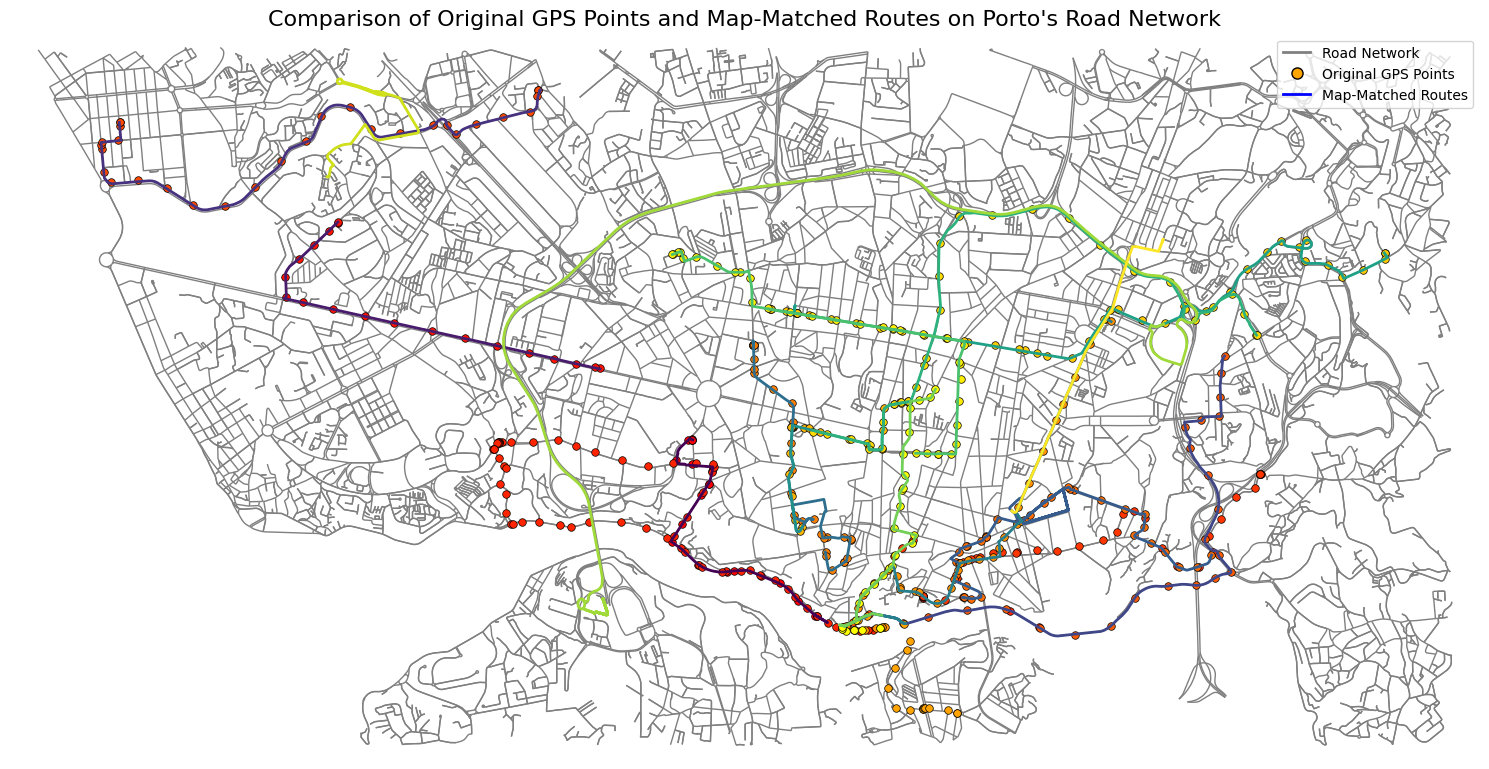

Image saved to data/Comparison_Original_vs_MapMatched.png


In [9]:
def visualize_and_compare_routes(map_matching_csv, original_trajectories_csv, output_image_path):
    # Check if the files exist
    if not os.path.exists(map_matching_csv):
        print(f"File not found: {map_matching_csv}")
        return
    if not os.path.exists(original_trajectories_csv):
        print(f"File not found: {original_trajectories_csv}")
        return
    
    df_matched = pd.read_csv(map_matching_csv)
    geometries_matched = []
    for idx, wkt in enumerate(df_matched['mgeom']):
        try:
            geometry = loads(wkt)
            geometries_matched.append(geometry)
        except Exception as e:
            print(f"Error parsing WKT at index {idx}: {e}")
            geometries_matched.append(None)
    df_matched['geometry'] = geometries_matched
    df_matched = df_matched.dropna(subset=['geometry'])
    
    if df_matched.empty:
        print("No valid map-matched geometries found.")
        return
    

    gdf_matched = gpd.GeoDataFrame(df_matched, geometry='geometry', crs="EPSG:4326")

    df_original = pd.read_csv(original_trajectories_csv, nrows=15)
    
    trajectories = []
    trajectory_count = 0
    x_max = y_max = x_min = y_min = 0
    is_first = True
    
    for polyline in df_original['POLYLINE']:
        polyline = polyline[2: -2]
        trajectory = []
        
        if len(polyline) <= 2:
            print(f'Skip empty row {trajectory_count}: Length={len(polyline)}, Element={polyline}')
        else:
            for coordinate in polyline.split('],['):
                try:
                    longitude, latitude = map(float, coordinate.strip().split(','))
                    trajectory.append((longitude, latitude))
                    x_max, y_max, x_min, y_min, is_first = calculate_boundaries(
                        x_max, y_max, x_min, y_min, is_first, longitude, latitude
                    )
                except Exception as e:
                    print(f"Error parsing coordinate '{coordinate}' in trajectory {trajectory_count}: {e}")
        
        trajectories.append(trajectory)
        trajectory_count += 1
    
    print(f'Original Trajectories Boundaries -> xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')
    
    # Calculate boundaries from map-matched routes
    current_x_max = current_y_max = current_x_min = current_y_min = None
    is_first_matched = True
    
    num_routes = min(15, len(gdf_matched))
    
    for i, geometry in enumerate(gdf_matched['geometry'].head(num_routes)):
        if geometry.geom_type == 'LineString':
            x, y = geometry.xy
            for lon, lat in zip(x, y):
                current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched = calculate_boundaries(
                    current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched, lon, lat
                )
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                x, y = line.xy
                for lon, lat in zip(x, y):
                    current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched = calculate_boundaries(
                        current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched, lon, lat
                    )
    
    # Combine boundaries from both datasets
    if not is_first_matched:
        # Update original boundaries to include map-matched boundaries
        x_min = min(x_min, current_x_min)
        x_max = max(x_max, current_x_max)
        y_min = min(y_min, current_y_min)
        y_max = max(y_max, current_y_max)
    
    # Add padding
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    x_min_padded = x_min - x_padding
    x_max_padded = x_max + x_padding
    y_min_padded = y_min - y_padding
    y_max_padded = y_max + y_padding
    
    print(f'Combined Boundaries with Padding -> xMin: {x_min_padded}, yMin: {y_min_padded}, xMax: {x_max_padded}, yMax: {y_max_padded}')
    
    # Create the road network from OSM within the calculated boundaries
    boundary_polygon = Polygon([
        (x_min_padded, y_min_padded),
        (x_max_padded, y_min_padded),
        (x_max_padded, y_max_padded),
        (x_min_padded, y_max_padded)
    ])
    G = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    
    # Initialize plot
    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        bgcolor='white',
        edge_color='gray',
        node_size=0,
        figsize=(15, 15)
    )
    
    # Plot map-matched routes
    colors_matched = plt.cm.viridis(np.linspace(0, 1, num_routes))
    for i, geometry in enumerate(gdf_matched['geometry'].head(num_routes)):
        label = f"Map-Matched Trip {i+1}"
        if geometry.geom_type == 'LineString':
            x, y = geometry.xy
            ax.plot(x, y, color=colors_matched[i], linewidth=2, label=label)
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                x, y = line.xy
                ax.plot(x, y, color=colors_matched[i], linewidth=2)
            # Add an empty plot for the legend to avoid duplicate labels
            ax.plot([], [], color=colors_matched[i], linewidth=2, label=label)
        else:
            print(f"Unsupported geometry type at index {i}: {geometry.geom_type}")
    
    # Plot original GPS points
    color_map_original = plt.cm.autumn(np.linspace(0, 1, 15))
    for i, trajectory in enumerate(trajectories[:15]):
        if trajectory:  # Ensure there are points to plot
            x_coords, y_coords = zip(*trajectory)
            ax.scatter(x_coords, y_coords, s=30, color=color_map_original[i], edgecolor='k', linewidth=0.5, label=f'Original Trip {i+1}')
    
    # Adjust plot aesthetics
    ax.set_title("Comparison of Original GPS Points and Map-Matched Routes on Porto's Road Network", fontsize=16)
    ax.axis('off')  # Hide axis
    # Create custom legends
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', lw=2, label='Road Network'),
        Line2D([0], [0], marker='o', color='w', label='Original GPS Points',
               markerfacecolor='orange', markersize=8, markeredgecolor='k'),
        Line2D([0], [0], color='blue', lw=2, label='Map-Matched Routes')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize='medium')
    
    plt.tight_layout()
    
    # Save the plot
    output_dir = os.path.dirname(output_image_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(output_image_path, format='png', dpi=300)
    plt.show()
    
    print(f"Image saved to {output_image_path}")

# Example usage
if __name__ == "__main__":
    map_matching_csv = "data/map_matching.csv"
    original_trajectories_csv = "data/train-1500.csv"
    output_image_path = "data/Comparison_Original_vs_MapMatched.png"
    
    visualize_and_compare_routes(map_matching_csv, original_trajectories_csv, output_image_path)


In [3]:

def plot_individual_trip(ax, G, original_trajectory, matched_geometry, trip_number):
    """
    Plot the road network, original GPS points, and map-matched route for a single trip.
    """
    # Plot the road network
    ox.plot_graph(G, ax=ax, show=False, close=False, edge_color='gray', node_size=0, edge_linewidth=0.5)
    
    # Plot original GPS points
    if original_trajectory:
        x_coords, y_coords = zip(*original_trajectory)
        ax.scatter(x_coords, y_coords, s=30, color='orange', edgecolor='k', linewidth=0.5, label='Original GPS Points')
    
    # Plot map-matched route
    if matched_geometry:
        if matched_geometry.geom_type == 'LineString':
            x, y = matched_geometry.xy
            ax.plot(x, y, color='blue', linewidth=2, label='Map-Matched Route')
        elif matched_geometry.geom_type == 'MultiLineString':
            for line in matched_geometry:
                x, y = line.xy
                ax.plot(x, y, color='blue', linewidth=2)
            # Add a label for the legend
            ax.plot([], [], color='blue', linewidth=2, label='Map-Matched Route')
    
    # Set title and aesthetics
    ax.set_title(f"Trip {trip_number}", fontsize=12)
    ax.axis('off')
    
    # Add legend
    ax.legend(loc='upper right', fontsize='small')

def visualize_individual_trips(map_matching_csv, original_trajectories_csv, output_dir):

    if not os.path.exists(map_matching_csv):
        print(f"File not found: {map_matching_csv}")
        return
    if not os.path.exists(original_trajectories_csv):
        print(f"File not found: {original_trajectories_csv}")
        return
    
    df_matched = pd.read_csv(map_matching_csv)
    
    geometries_matched = []
    for idx, wkt in enumerate(df_matched['mgeom']):
        try:
            geometry = loads(wkt)
            geometries_matched.append(geometry)
        except Exception as e:
            print(f"Error parsing WKT at index {idx}: {e}")
            geometries_matched.append(None)
    df_matched['geometry'] = geometries_matched
    df_matched = df_matched.dropna(subset=['geometry'])
    
    if df_matched.empty:
        print("No valid map-matched geometries found.")
        return
    
    gdf_matched = gpd.GeoDataFrame(df_matched, geometry='geometry', crs="EPSG:4326")
    
    df_original = pd.read_csv(original_trajectories_csv, nrows=15)
    
    trajectories = []
    trajectory_count = 0
    x_max = y_max = x_min = y_min = 0
    is_first = True
    
    for polyline in df_original['POLYLINE']:
        polyline = polyline.strip()[2:-2]  
        trajectory = []
        
        if len(polyline) <= 2:
            print(f'Skip empty row {trajectory_count}: Length={len(polyline)}, Element={polyline}')
        else:
            for coordinate in polyline.split('],['):
                try:
                    longitude, latitude = map(float, coordinate.strip().split(','))
                    trajectory.append((longitude, latitude))
                    x_max, y_max, x_min, y_min, is_first = calculate_boundaries(
                        x_max, y_max, x_min, y_min, is_first, longitude, latitude
                    )
                except Exception as e:
                    print(f"Error parsing coordinate '{coordinate}' in trajectory {trajectory_count}: {e}")
        
        trajectories.append(trajectory)
        trajectory_count += 1
    
    print(f'Original Trajectories Boundaries -> xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')
    
    current_x_max = current_y_max = current_x_min = current_y_min = None
    is_first_matched = True
    
    num_routes = min(15, len(gdf_matched))
    
    for i, geometry in enumerate(gdf_matched['geometry'].head(num_routes)):
        if geometry.geom_type == 'LineString':
            x, y = geometry.xy
            for lon, lat in zip(x, y):
                current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched = calculate_boundaries(
                    current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched, lon, lat
                )
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                x, y = line.xy
                for lon, lat in zip(x, y):
                    current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched = calculate_boundaries(
                        current_x_max, current_y_max, current_x_min, current_y_min, is_first_matched, lon, lat
                    )
    
    if not is_first_matched:

        x_min = min(x_min, current_x_min)
        x_max = max(x_max, current_x_max)
        y_min = min(y_min, current_y_min)
        y_max = max(y_max, current_y_max)
    
    # Add padding
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    x_min_padded = x_min - x_padding
    x_max_padded = x_max + x_padding
    y_min_padded = y_min - y_padding
    y_max_padded = y_max + y_padding
    
    print(f'Combined Boundaries with Padding -> xMin: {x_min_padded}, yMin: {y_min_padded}, xMax: {x_max_padded}, yMax: {y_max_padded}')

    boundary_polygon = Polygon([
        (x_min_padded, y_min_padded),
        (x_max_padded, y_min_padded),
        (x_max_padded, y_max_padded),
        (x_min_padded, y_max_padded)
    ])
    G = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Plot each trip individually
    for trip_num in range(15):
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Get original trajectory
        original_trajectory = trajectories[trip_num]
        
        # Get map-matched geometry
        if trip_num < len(gdf_matched):
            matched_geometry = gdf_matched.iloc[trip_num].geometry
        else:
            matched_geometry = None
        
        # Plot the trip
        plot_individual_trip(ax, G, original_trajectory, matched_geometry, trip_num + 1)
        
        # Set overall title for the trip
        ax.set_title(f"Trip {trip_num + 1}: Original GPS vs. Map-Matched Route", fontsize=14)
        
        # Save the plot
        output_path = os.path.join(output_dir, f'Trip_{trip_num + 1}.png')
        plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Trip {trip_num + 1} plot saved to {output_path}")
    
    print("All individual trip plots have been generated and saved.")

# Example usage
if __name__ == "__main__":
    map_matching_csv = "data/map_matching.csv"
    original_trajectories_csv = "data/train-1500.csv"
    output_directory = "data/Individual_Trip_Plots"
    
    visualize_individual_trips(map_matching_csv, original_trajectories_csv, output_directory)


Error parsing WKT at index 2: ParseException: Expected number but encountered ')'
Error parsing WKT at index 3: ParseException: Expected number but encountered ')'
Error parsing WKT at index 9: ParseException: Expected number but encountered ')'
Error parsing WKT at index 15: ParseException: Expected number but encountered ')'
Error parsing WKT at index 31: ParseException: Expected number but encountered ')'
Error parsing WKT at index 33: ParseException: Expected number but encountered ')'
Error parsing WKT at index 39: ParseException: Expected number but encountered ')'
Error parsing WKT at index 57: ParseException: Expected number but encountered ')'
Error parsing WKT at index 59: ParseException: Expected number but encountered ')'
Error parsing WKT at index 64: ParseException: Expected number but encountered ')'
Error parsing WKT at index 86: ParseException: Expected number but encountered ')'
Error parsing WKT at index 101: ParseException: Expected number but encountered ')'
Error 

In [1]:
#json file format